In [77]:
# Import packages
### YOUR CODE HERE ### 
import numpy as np
import pandas as pd

# Pipeline
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
# This is the classifier
from xgboost import XGBClassifier

# This is the function that helps plot feature importance 
from xgboost import plot_importance

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

# This displays all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

# This module lets us save our models once we fit them.
import pickle

In [ ]:
#Notes
#vars with importance based on EDA: CryoSleep

In [4]:
data = pd.read_csv("/Users/marykristalinmallari/Library/CloudStorage/OneDrive-Personal/Study/Kaggle/Code_Practice/titanic_spaceship/train.csv")

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [34]:
data['TotalSpent'] = data['RoomService']+ data['FoodCourt']+data['ShoppingMall']+data['Spa'] +data['VRDeck']

In [69]:
notcryo = data[data['CryoSleep']==False]

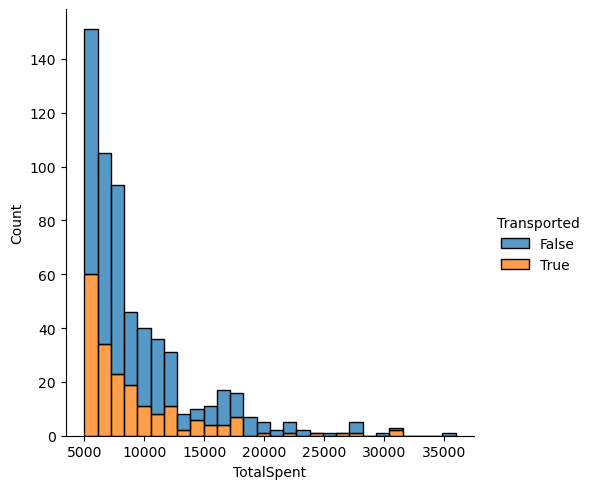

In [99]:
sns.displot(data = data[data['TotalSpent']>5000], x = 'TotalSpent', hue = 'Transported', multiple= 'stack')

In [73]:
cryo = data[data['CryoSleep']==True]

In [101]:
cryo['Transported'].value_counts()

Transported
True     2483
False     554
Name: count, dtype: int64

In [62]:
categoricalcols = ['HomePlanet','Destination']
boolcols = ['CryoSleep','VIP']

In [64]:
data[categoricalcols]=data[categoricalcols].astype('category')
data[boolcols]=data[boolcols].astype('boolean')

In [66]:
# assign X and y
X = data.drop(columns = ['Name','PassengerId','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Transported','Cabin'])
y = data['Transported']

In [156]:
# split data and set parameters
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = .2,random_state = 42)
xgb = XGBClassifier(objective = 'binary:logistic', random_state = 0, n_jobs = -1, enable_categorical = True)
cv_params = {'max_depth': [1,2,3,4,None],
             'min_child_weight': [1,2,3,4,5],
             'learning_rate': [0.1, 0.2, 0.3],
             'n_estimators': [20, 30, 40, 50, 70, 90],
             }  
scoring = ('accuracy', 'recall', 'precision','f1','neg_mean_absolute_error')
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='accuracy', n_jobs = -1)

# fit
xgb_cv.fit(X_train,y_train)

xgb_cv.best_score_

0.7405838147598385

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

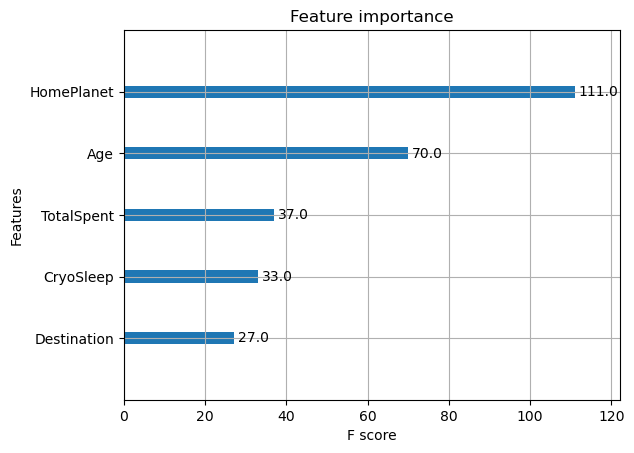

In [158]:
plot_importance(xgb_cv.best_estimator_)

In [160]:
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 40}

In [162]:
testdata = pd.read_csv("/Users/marykristalinmallari/Library/CloudStorage/OneDrive-Personal/Study/Kaggle/Code_Practice/titanic_spaceship/test.csv")

In [164]:
# data preprocessing
testdata['TotalSpent'] = testdata['RoomService']+ testdata['FoodCourt']+testdata['ShoppingMall']+testdata['Spa'] +testdata['VRDeck']
testdata[categoricalcols]=testdata[categoricalcols].astype('category')
testdata[boolcols]=testdata[boolcols].astype('boolean')
testX = data.drop(columns = ['Name','PassengerId','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Transported','Cabin'])

In [166]:
import os
os.chdir("/Users/marykristalinmallari/Library/CloudStorage/OneDrive-Personal/Study/Kaggle/Code_Practice/titanic_spaceship")

In [168]:
# predict and save to csv
test_pred = pd.DataFrame(xgb_cv.predict(testX))
test_pred = test_pred.rename(columns = {0:"Transported"})
test_pred = test_pred.astype('boolean')
predictions = pd.DataFrame(testdata['PassengerId'])
predictions = predictions.join(test_pred)
predictions.to_csv('titanic_spaceship_predictions_20241210_02.csv', index=False)